In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt

In [3]:
class GarbageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for cls_name in self.classes:
            class_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

full_dataset = GarbageClassificationDataset(root_dir=dataset_path)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

train_dataset = Subset(GarbageClassificationDataset(root_dir=dataset_path, transform=train_transform), train_indices)
val_dataset = Subset(GarbageClassificationDataset(root_dir=dataset_path, transform=val_transform), val_indices)


batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


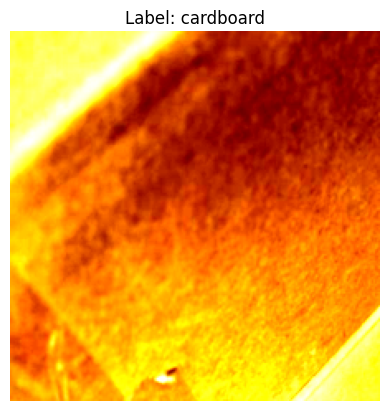

In [4]:
image, label = val_dataset[0]
image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f"Label: {full_dataset.classes[label]}")
plt.axis('off')
plt.show()

In [5]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 74.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib_metadata 8.7.0
    Uninstalling importlib_metadata-8.7.0:
      Successfully uninstalled importlib_metadata-8.7.0
ERROR: pip's dependency resolver does not currently take into account all the p

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from sklearn.metrics import accuracy_score,  precision_recall_fscore_support

import mlflow
import mlflow.pytorch
from tqdm.notebook import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)

num_classes = 6 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 89.6MB/s] 


In [8]:
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")  
mlflow.set_experiment("Garbage_Classification_EfficientNetB7")

2025/07/07 22:55:25 INFO mlflow.tracking.fluent: Experiment with name 'Garbage_Classification_EfficientNetB7' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/863375311781764890', creation_time=1751928925557, experiment_id='863375311781764890', last_update_time=1751928925557, lifecycle_stage='active', name='Garbage_Classification_EfficientNetB7', tags={}>

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    with mlflow.start_run():
        mlflow.log_param("model", "EfficientNet-B7")
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("num_epochs", num_epochs)

        best_acc = 0.0
        classes = full_dataset.classes

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for images, labels in tqdm(train_loader):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct / total

            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            y_true = []
            y_pred = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total

            precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)

            for i, class_name in enumerate(classes):
                mlflow.log_metric(f"precision_{class_name}", precision[i], step=epoch)
                mlflow.log_metric(f"recall_{class_name}", recall[i], step=epoch)

            scheduler.step(val_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            for i, class_name in enumerate(classes):
                print(f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}")


train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/20]
Train Loss: 0.7563, Train Acc: 74.47%
Val Loss: 0.6683, Val Acc: 79.25%
cardboard - Precision: 0.9737, Recall: 0.8315
glass - Precision: 0.7564, Recall: 0.6211
metal - Precision: 0.8125, Recall: 0.6989
paper - Precision: 0.9352, Recall: 0.9099
plastic - Precision: 0.6159, Recall: 0.9444
trash - Precision: 0.6538, Recall: 0.6071


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/20]
Train Loss: 0.3794, Train Acc: 87.28%
Val Loss: 1.2254, Val Acc: 78.46%
cardboard - Precision: 0.9726, Recall: 0.7978
glass - Precision: 0.8182, Recall: 0.6632
metal - Precision: 0.8158, Recall: 0.6667
paper - Precision: 0.8468, Recall: 0.9459
plastic - Precision: 0.5912, Recall: 0.9000
trash - Precision: 0.7895, Recall: 0.5357


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/20]
Train Loss: 0.3421, Train Acc: 89.66%
Val Loss: 0.5843, Val Acc: 85.97%
cardboard - Precision: 0.9863, Recall: 0.8090
glass - Precision: 0.7981, Recall: 0.8737
metal - Precision: 0.8211, Recall: 0.8387
paper - Precision: 0.9145, Recall: 0.9640
plastic - Precision: 0.8163, Recall: 0.8889
trash - Precision: 0.7895, Recall: 0.5357


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/20]
Train Loss: 0.2173, Train Acc: 92.68%
Val Loss: 0.9359, Val Acc: 82.41%
cardboard - Precision: 0.9610, Recall: 0.8315
glass - Precision: 0.8889, Recall: 0.6737
metal - Precision: 0.8434, Recall: 0.7527
paper - Precision: 0.8000, Recall: 0.9730
plastic - Precision: 0.7345, Recall: 0.9222
trash - Precision: 0.6923, Recall: 0.6429


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/20]
Train Loss: 0.2465, Train Acc: 92.38%
Val Loss: 0.8024, Val Acc: 83.60%
cardboard - Precision: 0.9863, Recall: 0.8090
glass - Precision: 0.8750, Recall: 0.8105
metal - Precision: 0.6547, Recall: 0.9785
paper - Precision: 0.9052, Recall: 0.9459
plastic - Precision: 0.8636, Recall: 0.6333
trash - Precision: 0.8750, Recall: 0.7500


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [6/20]
Train Loss: 0.1833, Train Acc: 94.56%
Val Loss: 0.8305, Val Acc: 84.98%
cardboard - Precision: 0.9710, Recall: 0.7528
glass - Precision: 0.8415, Recall: 0.7263
metal - Precision: 0.7944, Recall: 0.9140
paper - Precision: 0.9358, Recall: 0.9189
plastic - Precision: 0.7870, Recall: 0.9444
trash - Precision: 0.7097, Recall: 0.7857


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [7/20]
Train Loss: 0.1625, Train Acc: 94.85%
Val Loss: 0.7434, Val Acc: 85.77%
cardboard - Precision: 0.9630, Recall: 0.8764
glass - Precision: 0.8163, Recall: 0.8421
metal - Precision: 0.8542, Recall: 0.8817
paper - Precision: 0.9697, Recall: 0.8649
plastic - Precision: 0.7119, Recall: 0.9333
trash - Precision: 1.0000, Recall: 0.5000


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [8/20]
Train Loss: 0.1484, Train Acc: 94.80%
Val Loss: 0.4876, Val Acc: 87.75%
cardboard - Precision: 0.9012, Recall: 0.8202
glass - Precision: 0.9506, Recall: 0.8105
metal - Precision: 0.8900, Recall: 0.9570
paper - Precision: 0.8306, Recall: 0.9279
plastic - Precision: 0.8317, Recall: 0.9333
trash - Precision: 0.9474, Recall: 0.6429


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [9/20]
Train Loss: 0.1449, Train Acc: 95.70%
Val Loss: 0.4948, Val Acc: 88.14%
cardboard - Precision: 0.9620, Recall: 0.8539
glass - Precision: 0.9615, Recall: 0.7895
metal - Precision: 0.8913, Recall: 0.8817
paper - Precision: 0.9138, Recall: 0.9550
plastic - Precision: 0.8000, Recall: 0.9333
trash - Precision: 0.6389, Recall: 0.8214


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [10/20]
Train Loss: 0.1267, Train Acc: 96.34%
Val Loss: 0.7478, Val Acc: 83.99%
cardboard - Precision: 0.9452, Recall: 0.7753
glass - Precision: 0.9178, Recall: 0.7053
metal - Precision: 0.9733, Recall: 0.7849
paper - Precision: 0.9123, Recall: 0.9369
plastic - Precision: 0.6565, Recall: 0.9556
trash - Precision: 0.6500, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [11/20]
Train Loss: 0.1839, Train Acc: 94.31%
Val Loss: 0.6362, Val Acc: 85.57%
cardboard - Precision: 1.0000, Recall: 0.8315
glass - Precision: 0.7426, Recall: 0.7895
metal - Precision: 0.8421, Recall: 0.8602
paper - Precision: 0.9615, Recall: 0.9009
plastic - Precision: 0.8119, Recall: 0.9111
trash - Precision: 0.7097, Recall: 0.7857


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [12/20]
Train Loss: 0.1836, Train Acc: 94.76%
Val Loss: 0.6861, Val Acc: 86.76%
cardboard - Precision: 0.9625, Recall: 0.8652
glass - Precision: 0.7905, Recall: 0.8737
metal - Precision: 0.9091, Recall: 0.8602
paper - Precision: 0.9145, Recall: 0.9640
plastic - Precision: 0.8372, Recall: 0.8000
trash - Precision: 0.6667, Recall: 0.7143


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [13/20]
Train Loss: 0.1040, Train Acc: 96.78%
Val Loss: 0.5197, Val Acc: 89.72%
cardboard - Precision: 0.9080, Recall: 0.8876
glass - Precision: 0.9737, Recall: 0.7789
metal - Precision: 0.8878, Recall: 0.9355
paper - Precision: 0.9375, Recall: 0.9459
plastic - Precision: 0.7876, Recall: 0.9889
trash - Precision: 1.0000, Recall: 0.7143


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [14/20]
Train Loss: 0.0450, Train Acc: 98.91%
Val Loss: 0.5004, Val Acc: 89.92%
cardboard - Precision: 1.0000, Recall: 0.8764
glass - Precision: 0.9091, Recall: 0.8421
metal - Precision: 0.9326, Recall: 0.8925
paper - Precision: 0.9381, Recall: 0.9550
plastic - Precision: 0.8113, Recall: 0.9556
trash - Precision: 0.6875, Recall: 0.7857


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [15/20]
Train Loss: 0.0518, Train Acc: 98.76%
Val Loss: 0.3955, Val Acc: 92.09%
cardboard - Precision: 1.0000, Recall: 0.8764
glass - Precision: 0.9205, Recall: 0.8526
metal - Precision: 0.9348, Recall: 0.9247
paper - Precision: 0.9474, Recall: 0.9730
plastic - Precision: 0.8614, Recall: 0.9667
trash - Precision: 0.7879, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [16/20]
Train Loss: 0.0223, Train Acc: 99.31%
Val Loss: 0.3830, Val Acc: 92.69%
cardboard - Precision: 1.0000, Recall: 0.8764
glass - Precision: 0.9643, Recall: 0.8526
metal - Precision: 0.9355, Recall: 0.9355
paper - Precision: 0.9558, Recall: 0.9730
plastic - Precision: 0.8641, Recall: 0.9889
trash - Precision: 0.7429, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [17/20]
Train Loss: 0.0272, Train Acc: 99.36%
Val Loss: 0.3664, Val Acc: 92.69%
cardboard - Precision: 0.9873, Recall: 0.8764
glass - Precision: 0.9647, Recall: 0.8632
metal - Precision: 0.9341, Recall: 0.9140
paper - Precision: 0.9558, Recall: 0.9730
plastic - Precision: 0.8654, Recall: 1.0000
trash - Precision: 0.7647, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [18/20]
Train Loss: 0.0172, Train Acc: 99.51%
Val Loss: 0.3780, Val Acc: 92.49%
cardboard - Precision: 0.9873, Recall: 0.8764
glass - Precision: 0.9756, Recall: 0.8421
metal - Precision: 0.9247, Recall: 0.9247
paper - Precision: 0.9643, Recall: 0.9730
plastic - Precision: 0.8571, Recall: 1.0000
trash - Precision: 0.7429, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [19/20]
Train Loss: 0.0133, Train Acc: 99.65%
Val Loss: 0.3598, Val Acc: 93.08%
cardboard - Precision: 0.9873, Recall: 0.8764
glass - Precision: 0.9651, Recall: 0.8737
metal - Precision: 0.9255, Recall: 0.9355
paper - Precision: 0.9643, Recall: 0.9730
plastic - Precision: 0.8812, Recall: 0.9889
trash - Precision: 0.7647, Recall: 0.9286


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [20/20]
Train Loss: 0.0131, Train Acc: 99.55%
Val Loss: 0.3678, Val Acc: 92.69%
cardboard - Precision: 0.9873, Recall: 0.8764
glass - Precision: 0.9762, Recall: 0.8632
metal - Precision: 0.9158, Recall: 0.9355
paper - Precision: 0.9558, Recall: 0.9730
plastic - Precision: 0.8725, Recall: 0.9889
trash - Precision: 0.7576, Recall: 0.8929


In [10]:
import random

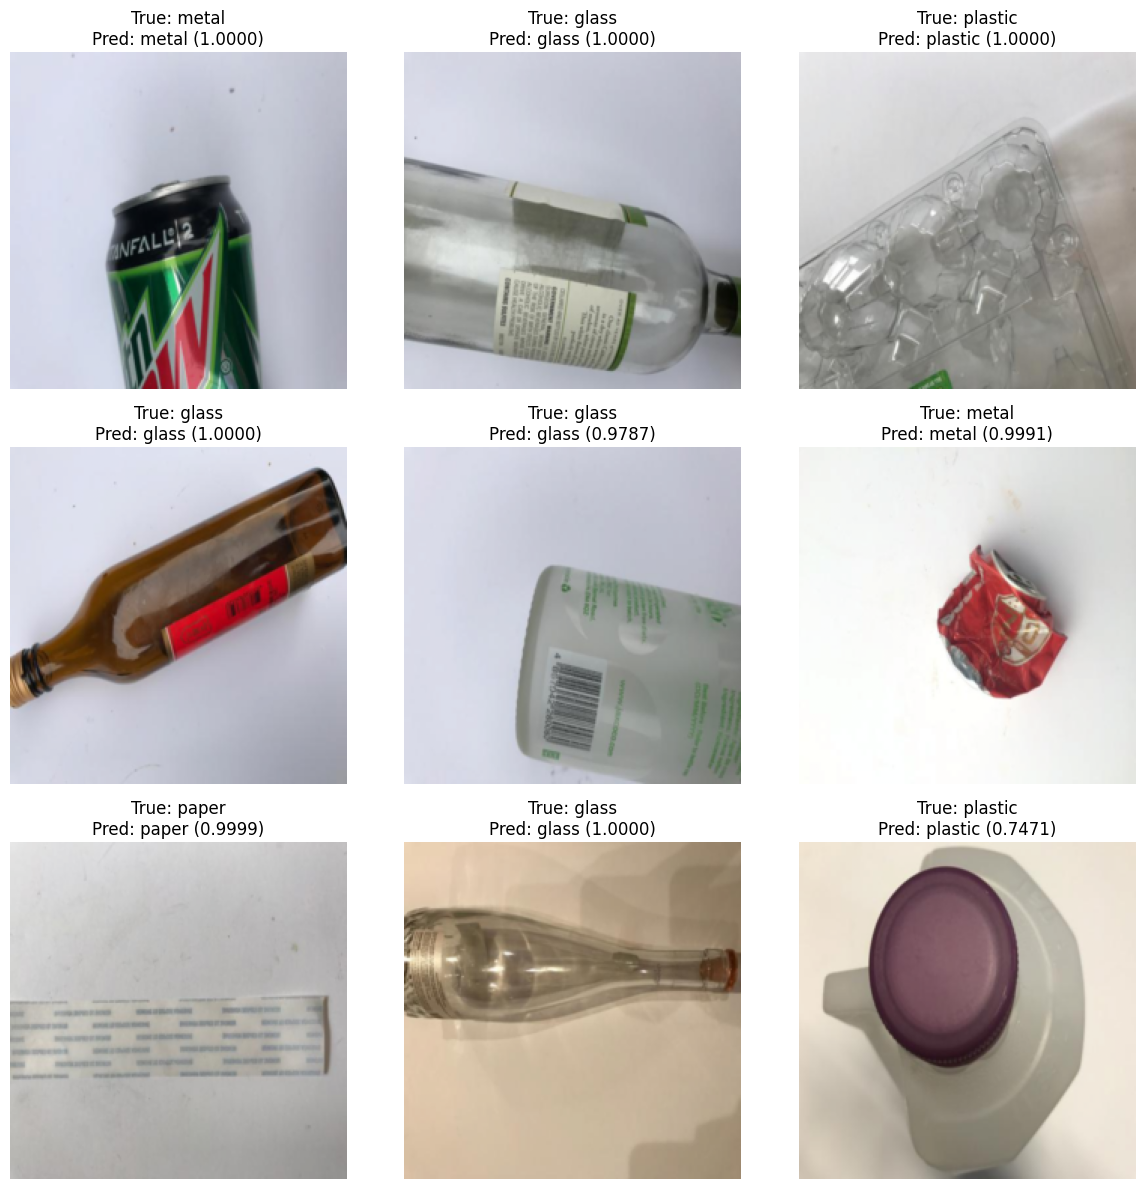

In [11]:
def inference(model, dataset, device, num_examples=9):
    model.eval()
    classes = dataset.dataset.classes
    indices = random.sample(range(len(dataset)), num_examples)
    denormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        image_tensor = image.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.softmax(output, dim=1)[0]
            _, pred_label = torch.max(output, 1)
            pred_label = pred_label.item()
            true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
            pred_prob = probs[pred_label].item()

        # print(f"Example {i+1}: True: {classes[true_label]}, Pred: {classes[pred_label]} (Prob: {pred_prob:.4f})")
        image = denormalize(image).cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]} ({pred_prob:.4f})")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
inference(model, val_dataset, device)

In [12]:
import shutil

shutil.make_archive('mlflow_archive', 'zip', '/kaggle/working/mlruns')

'/kaggle/working/mlflow_archive.zip'